In [1]:
import csv
import time

import alphashape
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from swimpde.ansatz import BasicAnsatz
from swimpde.boundary import Dirichlet
from swimpde.domain import Domain
from swimpde.equation import Helmholtz
from swimpde.solver import StaticSolver

from utils import compute_metrics

Parameters of the equation

In [2]:
def forcing(x: npt.ArrayLike):
    scales = np.array([1, 1, 4])
    sin_transforms = np.sin(np.pi * scales * x)
    u = 5 + np.prod(sin_transforms, axis=1)[:, None]
    u_xx = -18 * np.pi**2 * (u - 5)
    return u_xx - u

def solution(x: npt.ArrayLike) -> npt.ArrayLike:
    scales = np.array([1, 1, 4])
    sin_transforms = np.sin(np.pi * scales * x)
    return 5 + np.prod(sin_transforms, axis=1)[:, None]

boundary_condition = Dirichlet(solution)

Load the data

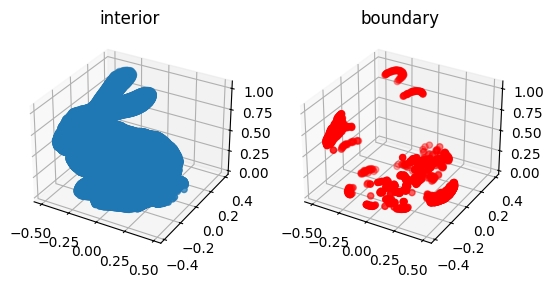

In [3]:
# Load the bunny points.
with open('data/bunny_vertices.csv') as fin:
    csvreader = csv.reader(fin)
    bunny_points = np.array(list(csvreader)).astype(float)

# Create alpha shape
alpha = 1e-4
alpha_shape = alphashape.alphashape(bunny_points, alpha)

# shape: (n_points, n_vertices)
vertices_mask = np.all(bunny_points[:, None, :] ==
                       alpha_shape.vertices[None, :, :],
                       axis=-1)
if (np.any(vertices_mask.sum(axis=0) != 1) or
    np.any(vertices_mask.sum(axis=1) > 1)):
    raise ValueError("Something went wrong with the mask.")

boundary_mask = np.any(vertices_mask, axis=1)
interior_points = bunny_points[~boundary_mask]
boundary_points = bunny_points[boundary_mask]

# Visualize the data
fig = plt.figure()
ax_int = fig.add_subplot(121, projection='3d')
ax_int.scatter(*interior_points.T)
ax_int.set_title("interior")

ax_bound = fig.add_subplot(122, projection='3d')
ax_bound.scatter(*boundary_points.T, c='r')
ax_bound.set_title("boundary");

Create a train/test split

In [4]:
rng = np.random.default_rng(42)
train_fraction = 0.7

def get_train_mask(rng: np.random.Generator,
                   n_points: int,
                   train_fraction: float):
    mask = np.zeros(n_points).astype(bool)
    train_indices = rng.choice(n_points,
                               size=int(n_points*train_fraction),
                               replace=False)
    mask[train_indices] = True
    return mask
    
interior_train_mask = get_train_mask(rng,
                                     interior_points.shape[0],
                                     train_fraction)
boundary_train_mask = get_train_mask(rng,
                                     boundary_points.shape[0],
                                     train_fraction)

train_interior = interior_points[interior_train_mask]
test_interior = interior_points[~interior_train_mask]
train_boundary = boundary_points[boundary_train_mask]
test_boundary = boundary_points[~boundary_train_mask]

Create data for evaluation

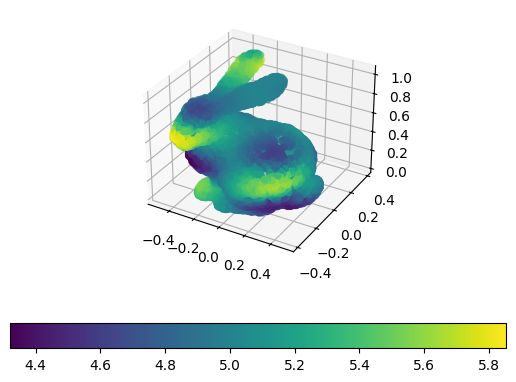

In [5]:
x_eval = np.concatenate([test_interior, test_boundary])
u_exact = solution(x_eval)

# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
eval_plot = ax.scatter(*x_eval.T, c=u_exact)
fig.colorbar(eval_plot, ax=ax, location='bottom')

# Create the domain
domain = Domain(interior_points=train_interior,
                boundary_points=train_boundary)

Solve the equation

In [6]:
# Parameters of the solver 
n_basis = 2000
activation = "tanh"
random_seed = 42
svd_cutoff = 1e-12
regularization_scale = 1e-12

In [7]:
# Define the domain.
domain = Domain(interior_points=train_interior,
                boundary_points=train_boundary)

# Define the basic ansatz.
ansatz = BasicAnsatz(
    n_basis=n_basis,
    activation=activation,
    random_seed=random_seed,
    svd_cutoff=svd_cutoff,
)

# Define the equation.
equation = Helmholtz()

# Define the solver.
solver = StaticSolver(
    domain=domain,
    boundary_condition=boundary_condition,
    equation=equation,
    ansatz=ansatz,
    f=forcing,
    regularization_scale=regularization_scale,
)

# Fir the solver.
start_fit = time.time()
solver.fit()
end_fit = time.time()
training_time = end_fit - start_fit

print(f"Training time: {training_time:.4f}s")

Training time: 6.0227s


Evaluate the solver

Relative error: 3.896E-03


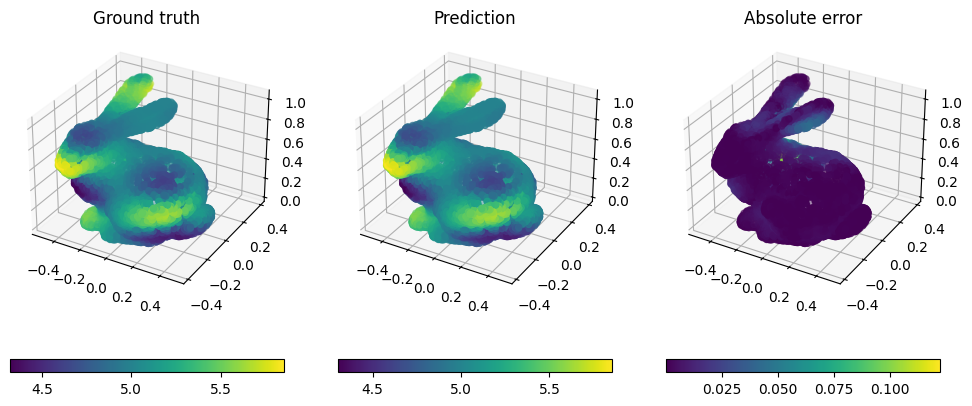

In [8]:
u_pred = solver.evaluate(x_eval)
abs_error, rel_l2_error = compute_metrics(u_pred, u_exact)

print(fr"Relative error: {rel_l2_error:.3E}")

data = {"Ground truth": u_exact,
        "Prediction": u_pred,
        "Absolute error": abs_error}

fig = plt.figure(figsize=(12, 5))
for i, label in enumerate(data):
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    sc = ax.scatter(*x_eval.T, c=data[label])
    fig.colorbar(sc, ax=ax, location='bottom')
    ax.set_title(label)